In [3]:
#import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.callbacks import *

In [4]:
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile

In [48]:
path = Path('/DATA/WAMRI/salk/uri/BPHO/')
path_processed = path/'processed'
path_hr = path/'hires'
path_lr = path/'lores'
path_test = path/'test'

path_hr.mkdir(exist_ok=True)
path_lr.mkdir(exist_ok=True)
path_test.mkdir(exist_ok=True)

In [6]:
def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)


def process_czi(proc_fn):
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            for depth in range(depths):
                idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                img = data[idx]
                save_proc_fn = path_hr/f'{proc_fn.stem}_{channel:02d}_{depth:03d}.npy'
                np.save(save_proc_fn, img)
        

In [7]:
#proc_fns = list(path_processed.glob('*.czi'))
#for fn in progress_bar(proc_fns):
#    process_czi(fn)

In [8]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    data = np.load(fn)
    data = data.astype(float) / 8000.0
    data *= 255
    data = data.astype(np.uint8)
    
    img = PIL.Image.fromarray(data, mode='L')
    targ_sz = resize_to(img,96,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)
    img.save(str(dest).replace('.npy','.jpg'), quality=100)

In [9]:
# hr_fns = list(path_hr.glob('*.npy'))
# parallel(resize_one, hr_fns)

In [10]:
class ProcImageList(ImageImageList):
    def open(self, fn):
        data = np.load(fn)
        x = torch.from_numpy(data[None,:,:].astype(np.float32))
        x.div_(8000.)
        return Image(x.repeat([3,1,1]))


In [11]:
def get_basename(x):
    return x.stem.split('_')[0]

base_names = list(set([get_basename(x) for x in list(path_lr.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    xbase = get_basename(x)
    return xbase in valid_names

src = (ImageItemList
       .from_folder(path_lr, label_cls=ProcImageList, extensions=".jpg", mode='L')
       .split_by_valid_func(is_validation_basename))

def get_data(src,bs,size, **kwargs):
    def lr_to_hr_fn(x):
        x_hr = path_hr/str(x.stem + ".npy")
        return x_hr
    
    data = (src.label_from_func(lr_to_hr_fn)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs,**kwargs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [12]:
arch = models.resnet34
bs,size = 32,128
data = get_data(src, bs, size)

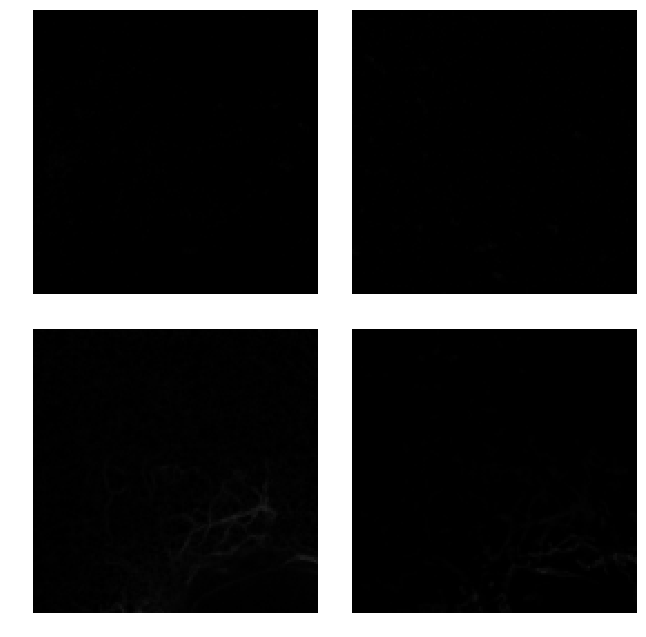

In [13]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
base_loss = F.l1_loss

In [16]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [17]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [18]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [20]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)
gc.collect();

In [21]:
# learn.lr_find()
# learn.recorder.plot()

In [22]:
lr = 1e-2
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)
    learn.recorder.plot_losses()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,5.363285,5.413240,1.368264,0.291821,0.407197,0.046698,1.152463,2.125030,0.021768
2,5.018515,4.815394,1.270305,0.258556,0.370520,0.037057,0.989918,1.874694,0.014345
3,4.495222,4.008349,0.959984,0.208418,0.308313,0.021974,0.882155,1.620611,0.006894
4,3.619516,2.282713,0.109802,0.185474,0.250437,0.015158,0.742917,0.974530,0.004395
5,2.845674,2.368962,0.040858,0.186090,0.248612,0.014282,0.781680,1.093323,0.004116
6,2.382840,2.070060,0.028447,0.182709,0.247886,0.012958,0.625959,0.968474,0.003627
7,2.009968,1.929856,0.040556,0.210577,0.253219,0.014954,0.458855,0.947530,0.004166
8,1.796417,1.651708,0.035468,0.180184,0.223857,0.013329,0.437873,0.757364,0.003633
9,1.664138,1.516137,0.032117,0.187421,0.210925,0.013187,0.395124,0.673770,0.003592
10,1.579847,1.506885,0.030426,0.181824,0.207076,0.012554,0.414838,0.656689,0.003477


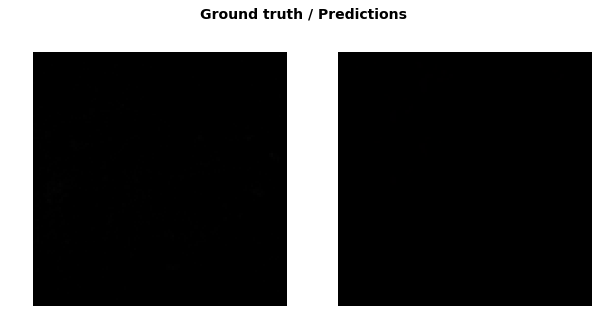

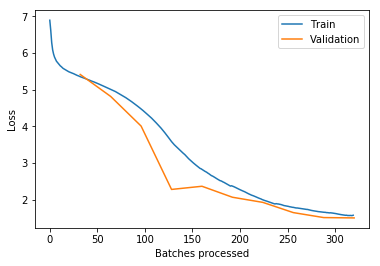

In [23]:
do_fit('1a', slice(lr*10))

In [24]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.356610,1.355368,0.029556,0.183587,0.202368,0.012135,0.336806,0.587512,0.003404
2,1.380604,1.395295,0.030413,0.185849,0.203883,0.012359,0.347257,0.612106,0.003428
3,1.354202,1.371100,0.029014,0.177968,0.201122,0.012051,0.355643,0.591915,0.003387
4,1.344860,1.347537,0.025650,0.174827,0.198546,0.011685,0.339264,0.594230,0.003335
5,1.329407,1.317063,0.025963,0.178528,0.199313,0.011886,0.324436,0.573548,0.003388
6,1.350877,1.618720,0.024907,0.173319,0.213083,0.011964,0.438661,0.753397,0.003389
7,1.342367,1.459693,0.026433,0.173915,0.200528,0.011977,0.397385,0.646063,0.003392
8,1.343410,2.172606,0.033417,0.222374,0.241506,0.013511,0.483028,1.175167,0.003602
9,1.331455,1.639531,0.025885,0.176076,0.217285,0.011736,0.413494,0.791722,0.003334
10,1.319839,1.280308,0.026236,0.177632,0.194286,0.011699,0.313910,0.553196,0.003349


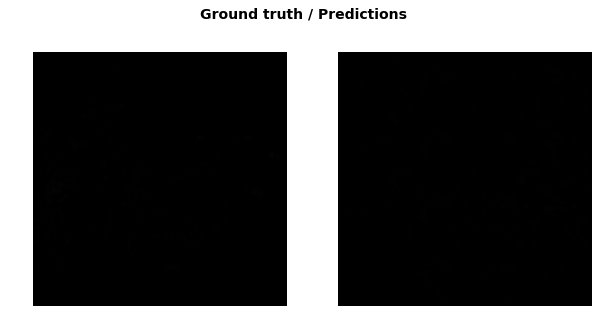

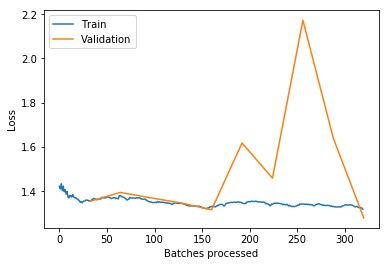

In [25]:
do_fit('1b', slice(1e-4,1e-2))

In [26]:
data = get_data(src, bs//2,size*2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.979409,0.971427,0.027397,0.163656,0.165039,0.008294,0.275650,0.329736,0.001656
2,0.975600,0.942827,0.030431,0.165781,0.167718,0.008579,0.267207,0.301406,0.001705
3,0.964439,0.975576,0.031393,0.163615,0.167950,0.008522,0.294595,0.307780,0.001722
4,0.981873,1.106610,0.024410,0.162363,0.171040,0.008409,0.375829,0.362903,0.001656
5,0.954411,1.011643,0.031162,0.166986,0.170825,0.008482,0.304241,0.328288,0.001658
6,0.985223,1.139137,0.036136,0.164133,0.184448,0.009242,0.343649,0.399691,0.001837
7,1.008258,1.163462,0.026701,0.161777,0.174873,0.008621,0.420243,0.369547,0.001701
8,1.009598,0.999211,0.039789,0.172864,0.170685,0.008788,0.277654,0.327721,0.001710
9,1.010911,1.048999,0.037571,0.165511,0.172820,0.008458,0.308085,0.354864,0.001690
10,0.976968,0.934398,0.028377,0.161569,0.164862,0.008436,0.262090,0.307416,0.001649


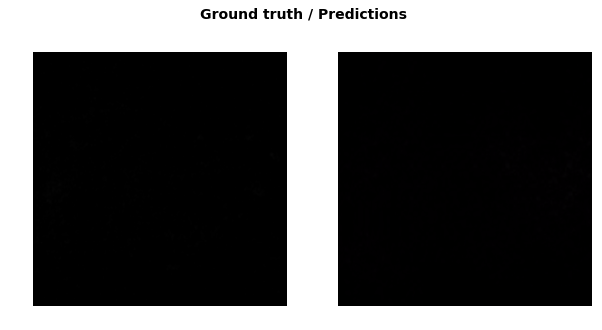

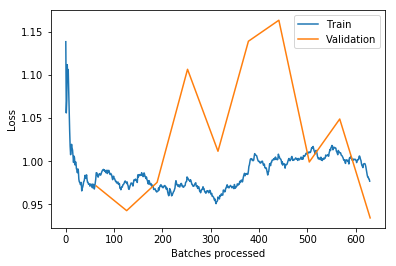

In [27]:
do_fit('2a')

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.919304,0.908282,0.025397,0.159426,0.163407,0.008273,0.257086,0.293066,0.001627
2,0.900084,0.890434,0.024400,0.161185,0.163819,0.008226,0.243395,0.287781,0.001627
3,0.884493,0.939681,0.023806,0.157672,0.165637,0.008239,0.281297,0.301390,0.001640
4,0.875931,0.894992,0.024477,0.160101,0.163945,0.008290,0.251013,0.285526,0.001640
5,0.878897,0.872770,0.025559,0.159884,0.162661,0.008260,0.233909,0.280866,0.001631
6,0.867587,0.942039,0.024386,0.157700,0.163995,0.008247,0.278268,0.307813,0.001629
7,0.853598,0.879342,0.023912,0.158569,0.162709,0.008202,0.242742,0.281585,0.001622
8,0.854157,0.875977,0.023835,0.159285,0.162690,0.008200,0.239412,0.280934,0.001622
9,0.847114,0.865506,0.024137,0.160650,0.162809,0.008255,0.229566,0.278460,0.001631
10,0.851751,0.864923,0.023796,0.160251,0.162814,0.008221,0.230717,0.277496,0.001629


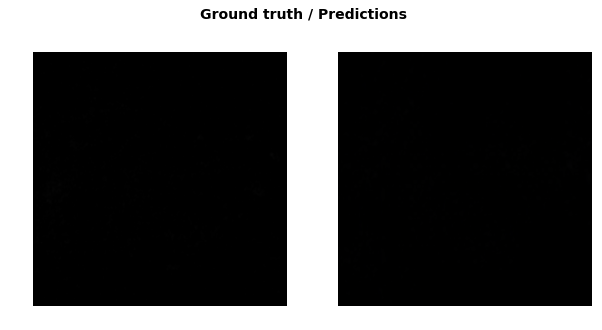

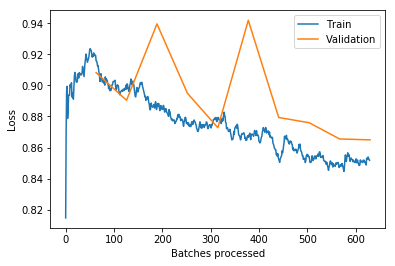

In [29]:
do_fit('2b', slice(1e-5,1e-3), pct_start=0.3)

In [35]:
tst_imgs  = list(Path('/DATA/WAMRI/salk/uri/Image_restoration_data/newimg/').iterdir())

In [56]:
fn = tst_imgs[1]
img = open_grayscale(fn)

a,b,c = learn.predict(img)

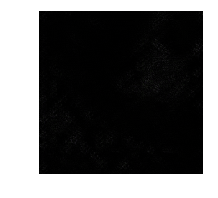

In [58]:
a.show()